# Cab-Driver Agent

## Imports

### Import and mount google drive (Required on google colab)

In [1]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive

### Import libraries
**Note: Please use keras version 2.2.4 since the model was saved using the new version, it won't load with older version**

In [2]:
import numpy as np
import random
import math
import datetime
import itertools
import collections
import pickle
import pandas as pd
from collections import deque

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from keras.models import load_model

from scipy.stats import zscore

# for plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from Env import CabDriver

/Users/saman.tamkeen/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
print('Time matrix shape: ', Time_matrix.shape)
print('Time taken in hours from location 1 to location 0 on 11 am on 05th day of week: ', Time_matrix[1][0][11][5])

Time matrix shape:  (5, 5, 24, 7)
Time taken in hours from location 1 to location 0 on 11 am on 05th day of week:  5.0


In [4]:
zero_vals_state_action = []
for p in range(Time_matrix.shape[0]):
  for q in range(Time_matrix.shape[1]):
    for hour in range(Time_matrix.shape[2]):
      for day in range(Time_matrix.shape[3]):
        if Time_matrix[p][q][hour][day] == 0 and p != q:
          for z in range(1,Time_matrix.shape[0]+1):
            zero_vals_state_action.append(((z,hour,day),(p+1,q+1)))
print('Number of actions with 0 time taken: ', len(zero_vals_state_action[0:10]))
print(random.sample(zero_vals_state_action,10))

Number of actions with 0 time taken:  10
[((5, 14, 3), (5, 1)), ((4, 12, 2), (5, 2)), ((2, 19, 4), (5, 3)), ((4, 19, 4), (2, 5)), ((2, 18, 3), (4, 3)), ((3, 21, 5), (3, 5)), ((1, 15, 2), (2, 5)), ((3, 12, 5), (5, 1)), ((3, 19, 0), (4, 1)), ((2, 20, 0), (3, 5))]


## Test Rig for Environment 

In [5]:
driver_env = CabDriver(debug=True)

CabDriver initialized with following config {'action_space': [(1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (0, 0)], 'state_space_length': 840, 'state_size': 36, 'total_reward': 0, 'total_time_consumed': 0, 'total_time_steps': 0, 'state_init': (3, 15, 1)}


In [6]:
# Check Requests
actions = driver_env.requests(driver_env.state_init)

# select random action
action = random.choice(actions)
print('Random Action Selected : ', action)
print()

# Check Rewards Earned and Next state for random Action
next_state, reward, is_terminal = driver_env.step(driver_env.state_init, action)

print('Reward Value : ',reward)
print('Next State Value : ',next_state)
print('Is terminal : ',is_terminal)
print('Tracking info: ', driver_env.tracking_info())
print()

# Check Rewards Earned and Next state for Action - (0,0) - Driver didn't take any request.
next_state, reward, is_terminal = driver_env.step(driver_env.state_init,(0,0))
print('Reward Value : ',reward)
print('Next State Value : ',next_state)
print('Is terminal : ',is_terminal)
print('Tracking info: ', driver_env.tracking_info())
print()

state_encode_v1 = driver_env.encode_state_v1(driver_env.state_init)
print('encode_state_v1: ', state_encode_v1.shape)

state_encode_v2 = driver_env.encode_state_v2(driver_env.state_init)
print('encode_state_v2: ', state_encode_v2.shape)

possible actions:  (3, 15, 1)  ->  [(3, 1), (3, 2), (4, 5), (2, 1), (0, 0), (2, 4), (4, 3), (1, 5)]
Random Action Selected :  (3, 1)

step:  {'state': (3, 15, 1), 'action': (3, 1), 'time_spent_for_pickup': 0, 'pickup_hour': 15, 'pickup_day': 1, 'time_spent_for_ride': 3}
Reward Value :  12
Next State Value :  (1, 18, 1)
Is terminal :  False
Tracking info:  (12, 3, 1)

step:  {'state': (3, 15, 1), 'action': (0, 0), 'time_spent_for_pickup': 1, 'pickup_hour': 16, 'pickup_day': 1, 'time_spent_for_ride': 0}
Reward Value :  -5
Next State Value :  (3, 16, 1)
Is terminal :  False
Tracking info:  (7, 4, 2)

encode_state_v1:  (3, 15, 1)  ->  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
encode_state_v1:  (36,)
encode_state_v2:  (3, 15, 1)  ->  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [7]:
episode_num = []
accu_rewards = []
total_time = []
total_steps = []
episodes_max = 100

driver_env=CabDriver()

for i in range(1,episodes_max+1):
    driver_env.reset()
    state = driver_env.state_init
    is_terminal = False
    while not is_terminal:
        # random action selection
        actions = driver_env.requests(state)
        action = random.choice(actions)
        
        next_state, reward, is_terminal = driver_env.step(state, action)
        state = next_state
    
    tot_rewards, tot_time, steps = driver_env.tracking_info()
    episode_num.append(i)
    accu_rewards.append(tot_rewards)
    total_time.append(tot_time)
    total_steps.append(steps)
    
episodes_vs_rewards=pd.DataFrame(data={'Episode_Number':episode_num,
                                       'Accumulated_Rewards':accu_rewards,
                                       'Total_Time':total_time,
                                       'Total_Steps':total_steps})

In [8]:
episodes_vs_rewards.describe()

,Episode_Number,Accumulated_Rewards,Total_Time,Total_Steps
count,100.000000,100.000000,100.000000,100.000000
mean,50.500000,-125.570000,723.840000,127.210000
std,29.011492,152.592099,3.100081,8.686801
min,1.000000,-492.000000,720.000000,110.000000
25%,25.750000,-229.250000,721.000000,121.000000
50%,50.500000,-153.000000,723.000000,128.000000
75%,75.250000,-49.750000,726.000000,133.250000
max,100.000000,370.000000,733.000000,147.000000


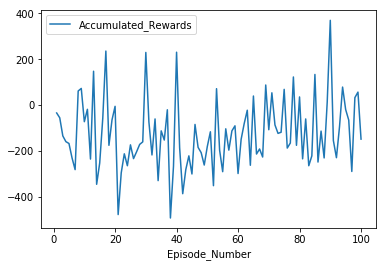

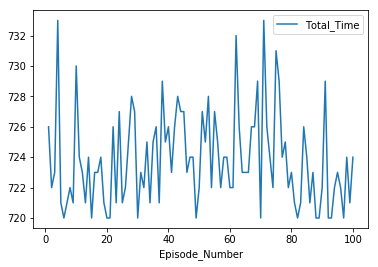

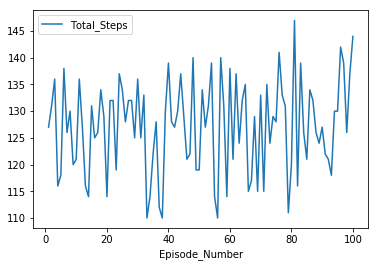

In [9]:
# Plot rewards vs Episodes
episodes_vs_rewards.plot(x='Episode_Number',y='Accumulated_Rewards')
episodes_vs_rewards.plot(x='Episode_Number',y='Total_Time')
episodes_vs_rewards.plot(x='Episode_Number',y='Total_Steps')

## Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [10]:
class DQNAgent:
    def __init__(self, state_size=None, action_size=None, discount_factor=0.95, learning_rate=0.01, 
                 epsilon_min=0., epsilon_max=1., epsilon_decay=-0.0001, batch_size=32, experience_buffer_size=2000,
                 debug=False, env=CabDriver(), state_encoding='v1'):
        # Define size of state and action
        
        if state_size is not None:
            self.state_size = state_size
        else:
            if state_encoding == 'v1':
                self.state_size = env.state_size
            elif state_encoding == 'v2':
                self.state_size = len(env.state_space)
            else:
                self.state_size = env.state_size


        if action_size is not None:
            self.action_size = action_size
        else:
            self.action_size = len(env.action_space)

        self.state_encoding = state_encoding
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate 
        self.epsilon_min = epsilon_min
        self.epsilon_max = epsilon_max
        self.epsilon = epsilon_max
        self.epsilon_decay = epsilon_decay
        self.timestep = 0
        
        self.batch_size = batch_size        
        # create replay memory using deque
        self.memory = deque(maxlen=experience_buffer_size)
        
        self.debug = debug
        self.env = env
        
        if self.debug:
            print('DQNAgent initialized with following params: ', {
                'state_size':self.state_size,
                'action_size':self.action_size,
                'state_encoding':self.state_encoding,
                'discount_factor':self.discount_factor,
                'learning_rate':self.learning_rate,
                'episodes_min':self.epsilon_min,
                'epsilon_max':self.epsilon_max,
                'epsilon':self.epsilon,
                'epsilon_decay':self.epsilon_decay,
                'batch_size':self.batch_size
            })

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()
        
        # initialize target model
        self.update_target_model()

    # approximate Q function using Neural Network
    def build_model(self):

        model = Sequential()

        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        if self.debug:
            model.summary()

        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

        return model

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        """
        get action in a state according to an epsilon-greedy approach
        """
        if np.random.rand() <= self.epsilon:
            # random action selection
            actions = self.env.requests(state)
            action = random.choice(actions)
            if self.debug:
                print('Random action chosen: ', action)
        else:
            # choose the action with the highest q(s, a)
            if self.state_encoding == 'v1':
                encoded_state = self.env.encode_state_v1(state)
            else:
                encoded_state = self.env.encode_state_v2(state)
            # the first index corresponds to the batch size, so reshape state to (1, state_size) so that the first index corresponds to the batch size
            encoded_state = encoded_state.reshape(1, self.state_size)
            q_value = self.model.predict(encoded_state)
            action = self.env.action_space[np.argmax(q_value[0])]
            if self.debug:
                print('Predicted action chosen: ', action)

        return action
      
    def get_q_value(self, state, action):
        if self.state_encoding == 'v1':
            encoded_state = self.env.encode_state_v1(state)
        else:
            encoded_state = self.env.encode_state_v2(state)
        encoded_state = encoded_state.reshape(1, self.state_size)
        q_value = self.model.predict(encoded_state)
        action_index = self.env.action_space.index(action)
        return q_value[0][action_index]

    def append_sample(self, state, action, reward, next_state, is_terminal):
        self.memory.append((state, action, reward, next_state, is_terminal))
        
    def decay_epsilon(self):
        # Decay in ε after we generate each sample from the environment       
        self.timestep = self.timestep + 1
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(self.epsilon_decay * self.timestep)
        if self.debug:
            print('new epsilon value: ', self.epsilon)
   
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """
        train the neural network on a minibatch. Input to the network is the states,
        output is the target q-value corresponding to each action.
        """
        if len(self.memory) >= self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            
            update_input = np.zeros((self.batch_size, self.state_size))
            update_target = np.zeros((self.batch_size, self.state_size))
            action, reward, is_terminal = [], [], []
            
            for i in range(self.batch_size):
                if self.state_encoding == 'v1':
                    update_input[i] = self.env.encode_state_v1(mini_batch[i][0])
                    update_target[i] = self.env.encode_state_v1(mini_batch[i][3])
                else:
                    update_input[i] = self.env.encode_state_v2(mini_batch[i][0])
                    update_target[i] = self.env.encode_state_v2(mini_batch[i][3])
                action.append(mini_batch[i][1])
                reward.append(mini_batch[i][2])
                is_terminal.append(mini_batch[i][4])
 
            # predict the target q-values from states s
            target = self.model.predict(update_input)

            # target for q-network
            target_qval = self.target_model.predict(update_target)

            # update the target values
            for i in range(self.batch_size):
                action_index = self.env.action_space.index(action[i])
                if is_terminal[i]:
                    target[i][action_index] = reward[i]
                else:
                    target[i][action_index] = reward[i] + self.discount_factor * (np.amax(target_qval[i]))

            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save(self, name):
        self.model.save(name)

## DQN block

In [11]:
scores, timesteps, episodes = [], [], []
state_action_sample = {}

def train_agent(episodes_to_run=1000, model_name='model.hd5', debug=False, state_encoding='v1',
                episode_info_frequency=50, model_save_frequency=50, **agent_args):
    env = CabDriver(debug=debug)
    agent = DQNAgent(debug=debug, state_encoding=state_encoding, **agent_args)
    
    # randomly sample 0.1% of state-action pairs for tracking convergence
    state_action_to_sample = random.sample([(state,action) for state,action in itertools.product(env.state_space, env.action_space)], math.ceil(0.001*len(env.state_space)*len(env.action_space)))
    for state,action in state_action_to_sample:
        state_action_sample.update({(state,action):[]})

    for episode in range(episodes_to_run):    
        is_terminal = False
        score = 0
        state = env.reset()
        rewards = []

        while not is_terminal:
            # Write your code here
            # 1. Pick epsilon-greedy action from possible actions for the current state
            # 2. Evaluate your reward and next state
            # 3. Append the experience to the memory
            # 4. Train the model by calling function agent.train_model
            # 5. Keep a track of rewards, Q-values, loss

            # get action for the current state and go one step in environment
            action = agent.get_action(state)
            next_state, reward, is_terminal = env.step(state, action)
            rewards.append(reward)
            agent.append_sample(state, action, reward, next_state, is_terminal)
            agent.decay_epsilon()
            agent.train_model()
            
            if (state,action) in state_action_to_sample:
                q_value = agent.get_q_value(state, action)
                state_action_sample[(state,action)].append(q_value)

            state = next_state

        agent.update_target_model()
        total_rewards, episode_length, total_timesteps = env.tracking_info()
        scores.append(total_rewards)
        timesteps.append(total_timesteps)
        episodes.append(episode)

        if episode % episode_info_frequency == 0:
            print("episode:", episode, "  score:", total_rewards, "  requests:", total_timesteps, "  memory length:", len(agent.memory), "  timesteps:", agent.timestep, "  epsilon:", agent.epsilon, "  last 200 std dev:", np.std(scores[-200:]))

        if episode % model_save_frequency == 0:
            agent.save(model_name)

    print("episode:", episode, "  score:", total_rewards, "  requests:", total_timesteps, "  memory length:", len(agent.memory), "  timesteps:", agent.timestep, "  epsilon:", agent.epsilon, "  last 200 std dev:", np.std(scores[-200:]))
    agent.save(model_name)

### Test dqn training block for 1 episode

In [12]:
train_agent(episodes_to_run=1, model_name='test.hd5', debug=True, epsilon_decay=-0.00005)

CabDriver initialized with following config {'action_space': [(1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (0, 0)], 'state_space_length': 840, 'state_size': 36, 'total_reward': 0, 'total_time_consumed': 0, 'total_time_steps': 0, 'state_init': (2, 3, 1)}
DQNAgent initialized with following params:  {'state_size': 36, 'action_size': 21, 'state_encoding': 'v1', 'discount_factor': 0.95, 'learning_rate': 0.01, 'episodes_min': 0.0, 'epsilon_max': 1.0, 'epsilon': 1.0, 'epsilon_decay': -5e-05, 'batch_size': 32}
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1184      
_________________________________________________________________
dense_2 (Dense)              (None, 32) 

Random action chosen:  (4, 2)
step:  {'state': (3, 9, 5), 'action': (4, 2), 'time_spent_for_pickup': 2, 'pickup_hour': 11, 'pickup_day': 5, 'time_spent_for_ride': 4}
new epsilon value:  0.9983513605016212
Random action chosen:  (3, 5)
step:  {'state': (2, 15, 5), 'action': (3, 5), 'time_spent_for_pickup': 2, 'pickup_hour': 17, 'pickup_day': 5, 'time_spent_for_ride': 0}
new epsilon value:  0.9983014441815146
Random action chosen:  (5, 3)
step:  {'state': (5, 17, 5), 'action': (5, 3), 'time_spent_for_pickup': 0, 'pickup_hour': 17, 'pickup_day': 5, 'time_spent_for_ride': 0}
new epsilon value:  0.9982515303571615
Random action chosen:  (2, 4)
step:  {'state': (3, 17, 5), 'action': (2, 4), 'time_spent_for_pickup': 2, 'pickup_hour': 19, 'pickup_day': 5, 'time_spent_for_ride': 2}
new epsilon value:  0.9982016190284373
Random action chosen:  (1, 2)
step:  {'state': (4, 21, 5), 'action': (1, 2), 'time_spent_for_pickup': 3, 'pickup_hour': 0, 'pickup_day': 6, 'time_spent_for_ride': 6}
new epsilon

Random action chosen:  (0, 0)
step:  {'state': (3, 8, 2), 'action': (0, 0), 'time_spent_for_pickup': 4, 'pickup_hour': 12, 'pickup_day': 2, 'time_spent_for_ride': 0}
new epsilon value:  0.9960079893439915
Random action chosen:  (3, 5)
step:  {'state': (3, 9, 2), 'action': (3, 5), 'time_spent_for_pickup': 0, 'pickup_hour': 9, 'pickup_day': 2, 'time_spent_for_ride': 4}
new epsilon value:  0.9959581901895135
Random action chosen:  (2, 5)
step:  {'state': (5, 13, 2), 'action': (2, 5), 'time_spent_for_pickup': 0, 'pickup_hour': 13, 'pickup_day': 2, 'time_spent_for_ride': 0}
new epsilon value:  0.995908393524931
Random action chosen:  (2, 3)
step:  {'state': (5, 13, 2), 'action': (2, 3), 'time_spent_for_pickup': 0, 'pickup_hour': 13, 'pickup_day': 2, 'time_spent_for_ride': 1}
new epsilon value:  0.9958585993501196
Random action chosen:  (4, 5)
step:  {'state': (3, 14, 2), 'action': (4, 5), 'time_spent_for_pickup': 4, 'pickup_hour': 18, 'pickup_day': 2, 'time_spent_for_ride': 4}
new epsilon v

episode: 0   score: -243   requests: 132   memory length: 132   timesteps: 132   epsilon: 0.9934217321629571   last 200 std dev: 0.0


### Train dqn agent with state_encoding v1

In [17]:
scores, timesteps, episodes = [], [], []
state_action_sample = {}
train_agent(episodes_to_run=20000, model_name='model_new.hd5', episode_info_frequency=200, epsilon_decay=-0.00005)

episode: 0   score: -432   requests: 116   memory length: 116   timesteps: 116   epsilon: 0.9942167875284308   last 200 std dev: 0.0
episode: 200   score: 1210   requests: 130   memory length: 2000   timesteps: 25103   epsilon: 0.28503309005416283   last 200 std dev: 350.6612124258969
episode: 400   score: 1229   requests: 132   memory length: 2000   timesteps: 48531   epsilon: 0.08834108418702025   last 200 std dev: 249.46519191061506
episode: 600   score: 1767   requests: 168   memory length: 2000   timesteps: 71456   epsilon: 0.028077127558000875   last 200 std dev: 231.11522148054203
episode: 800   score: 1922   requests: 110   memory length: 2000   timesteps: 94414   epsilon: 0.008908940107164826   last 200 std dev: 235.95077744097392
episode: 1000   score: 2395   requests: 101   memory length: 2000   timesteps: 117056   epsilon: 0.0028718467191210743   last 200 std dev: 277.2479593703081
episode: 1200   score: 1871   requests: 108   memory length: 2000   timesteps: 140443   epsil

### Save scores and cab requests per episode to numpy file

In [0]:
np_array = np.array([episodes,scores,timesteps])
np.save('result.npy', np_array)

### Save state action samples to pickle file

In [0]:
with open('state_action_sample.pickle', 'wb') as handle:
    pickle.dump(state_action_sample, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Track convergence

#### Plot reward and cab requests handled per episode

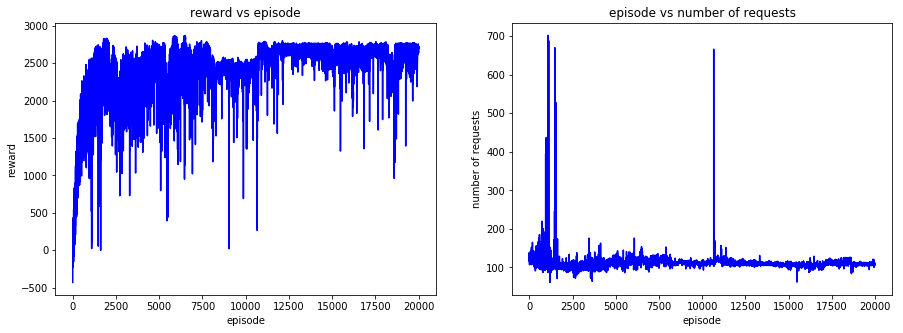

In [13]:
score_requests_array = np.load('result.npy')
episodes = score_requests_array[0]
scores = score_requests_array[1]
timesteps = score_requests_array[2]
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(episodes, scores, 'b')
plt.xlabel('episode')
plt.ylabel('reward')
plt.title('reward vs episode')


plt.subplot(122)
plt.plot(episodes, timesteps, 'b')
plt.xlabel('episode')
plt.ylabel('number of requests')
plt.title('episode vs number of requests')

plt.show()

#### Plot sampled q_values for state action pairs

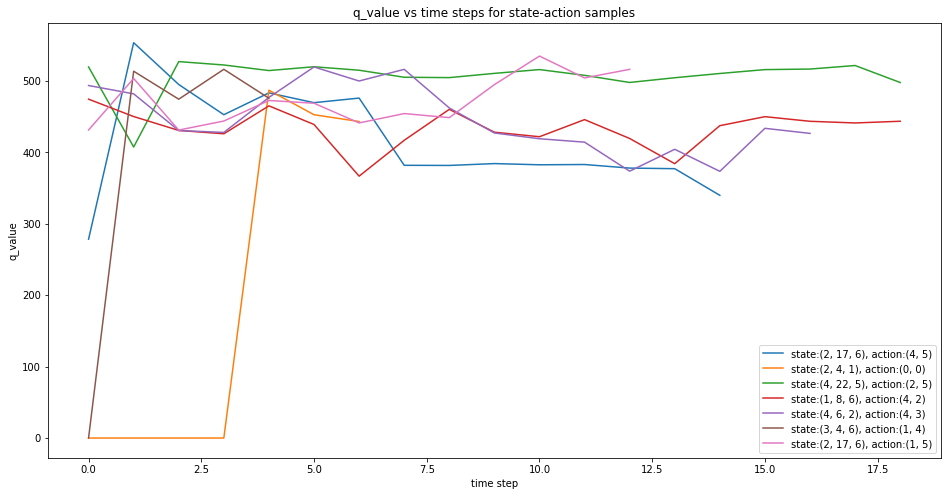

In [14]:
with open('state_action_sample.pickle', 'rb') as handle:
    state_action_sample = pickle.load(handle)

plt.figure(figsize=(16, 8))
for state_action,samples in filter(lambda elem: len(elem[1]) >= 5, state_action_sample.items()):
  plt.plot(samples, label='state:{}, action:{}'.format(state_action[0], state_action[1]))
    
plt.xlabel('time step')
plt.ylabel('q_value')
plt.title('q_value vs time steps for state-action samples')
plt.legend()

## Compare Change in Revenue for 2 Years (24 Episodes)

In [15]:
episodes_max = 24

manual_rewards = []
manual_time = []
manual_steps = []

model_rewards = []
model_time = []
model_steps = []

rl_model = load_model('model.hd5')

def test_sequence(manual=True):
    episode_num=[]
    total_time=[]
    total_steps=[]
    accu_rewards=[]
    
    driver_env=CabDriver()

    for i in range(1,episodes_max+1):
        driver_env.reset()
        state = driver_env.state_init
        is_terminal = False
        while not is_terminal:
            if manual:
                actions = driver_env.requests(state)
                action = random.choice(actions)
            else:
                encoded_state = driver_env.encode_state_v1(state)
                encoded_state = encoded_state.reshape(1,36)
                q_value = rl_model.predict(encoded_state)
                action = driver_env.action_space[np.argmax(q_value[0])]
            
            next_state, reward, is_terminal = driver_env.step(state, action)
            state = next_state
    
        tot_rewards, tot_time, steps = driver_env.tracking_info()
        episode_num.append(i)
        accu_rewards.append(tot_rewards)
        total_time.append(tot_time)
        total_steps.append(steps)
    
    return accu_rewards,total_time,total_steps

In [16]:
start_time=datetime.datetime.now() 
manual_rewards,manual_time,manual_steps=test_sequence()
end_time=datetime.datetime.now() 
print('Time Elapsed for Manual Selection : ',end_time-start_time)

Time Elapsed for Manual Selection :  0:00:00.120899


In [17]:
start_time=datetime.datetime.now() 
model_rewards,model_time,model_steps=test_sequence(manual=False)
end_time=datetime.datetime.now() 
print('Time Elapsed for RL_Model Selection : ',end_time-start_time)

Time Elapsed for RL_Model Selection :  0:00:00.967258


In [18]:
data={'manual_rewards':manual_rewards,
     'manual_time':manual_time,
     'manual_steps':manual_steps,
     'model_rewards':model_rewards,
     'model_time':model_time,
     'model_steps':model_steps,
     }
revenue=pd.DataFrame(data)

In [19]:
revenue[['manual_rewards','manual_steps','model_rewards','model_steps']].describe()

,manual_rewards,manual_steps,model_rewards,model_steps
count,24.000000,24.000000,24.000000,24.00000
mean,-123.833333,127.458333,2629.500000,109.62500
std,138.583727,8.123927,50.742316,1.76469
min,-397.000000,116.000000,2493.000000,107.00000
25%,-215.750000,122.000000,2623.000000,108.00000
50%,-125.000000,127.000000,2645.500000,110.00000
75%,-20.750000,132.250000,2662.500000,110.00000
max,110.000000,150.000000,2685.000000,114.00000


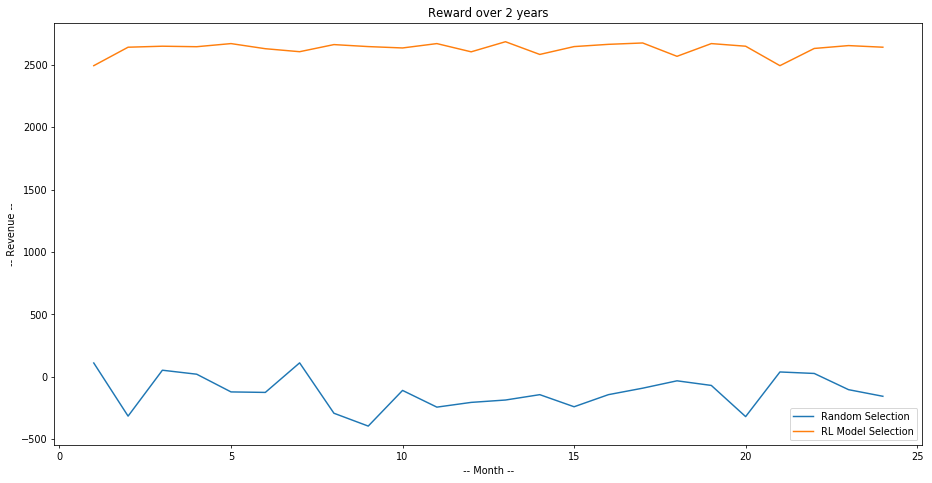

In [20]:
fig=plt.figure(figsize=(16, 8), dpi=70, facecolor='w', edgecolor='k')
sns.lineplot(y=revenue['manual_rewards'],x=range(1,len(revenue)+1),label='Random Selection')
sns.lineplot(y=revenue['model_rewards'],x=range(1,len(revenue)+1),label='RL Model Selection')
plt.xlabel(' -- Month -- ')
plt.ylabel(' -- Revenue -- ')
plt.title('Reward over 2 years')
plt.show()

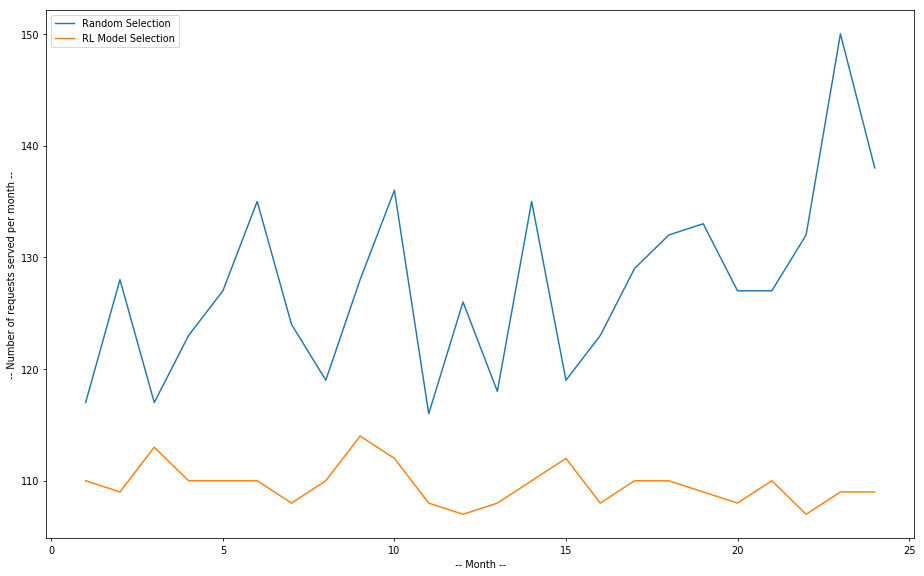

In [21]:
fig=plt.figure(figsize=(16, 10), dpi=70, facecolor='w', edgecolor='k')
sns.lineplot(y=revenue['manual_steps'],x=range(1,len(revenue)+1),label='Random Selection')
sns.lineplot(y=revenue['model_steps'],x=range(1,len(revenue)+1),label='RL Model Selection')
plt.xlabel(' -- Month -- ')
plt.ylabel(' -- Number of requests served per month -- ')
plt.show()

## Epsilon-decay function
epsilon-decay function for the model.

In [22]:
time = np.arange(0,100000)
epsilon_min=0
epsilon_max=1
epsilon_decay=-0.00005

epsilons = []
random_actions = []

for i in range(0,100000):
    epsilon = epsilon_min + (epsilon_max - epsilon_min) * np.exp(epsilon_decay*i)
    if np.random.rand() <= epsilon:
        action = 1
    else:
        action = 0
    epsilons.append(epsilon)
    random_actions.append(action)

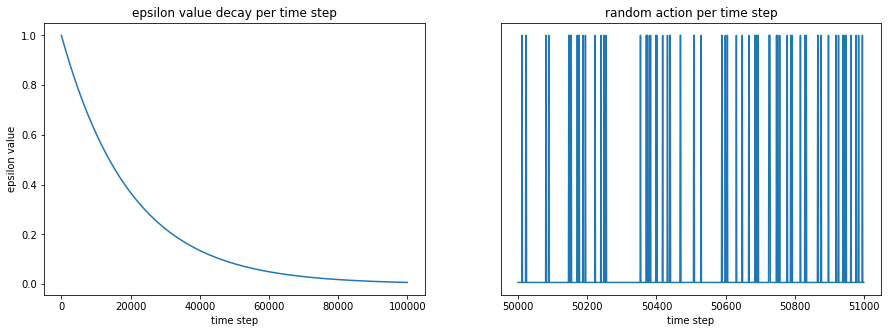

In [23]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(time, epsilons)
plt.xlabel('time step')
plt.ylabel('epsilon value')
plt.title('epsilon value decay per time step')

plt.subplot(122)
plt.plot(time[50000:51000], random_actions[50000:51000])
plt.xlabel('time step')
plt.yticks([])
plt.title('random action per time step')

plt.show()